# [프로젝트] 멀티모달 데이터를 처리하는 RAG- Part 2

질문에 대한 맥락을 검색하여 LLM에 전달하는 RAG는 이미지/표와 같은 데이터를 처리하기 어렵다는 단점이 있습니다.   

Gemini와 같은 멀티모달 모델을 통해, Docling으로 불러온 이미지/표의 정보를 텍스트로 변환해 보겠습니다.

이를 통해, 텍스트 이외에 이미지의 캡션을 포함한 DB를 구성하여 RAG를 수행합니다.

![Image](https://github.com/user-attachments/assets/568ae91a-efb4-4492-bd0b-a492d3e2385c)

**GPU 클라우드 T4를 설정해 주세요!**

In [ ]:
!pip install langgraph dotenv docling google-generativeai langchain_huggingface sentence_transformers jsonlines langchain langchain-google-genai langchain-community langchain_chroma chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 4.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of langchain-google-genai to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.6/159.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

설치 후 세션을 재시작합니다.    

**Gemini 실행을 위해, .env 파일도 업로드해 주세요!**

In [ ]:
import os
import re
import base64
import logging
import time
import uuid
from pathlib import Path
from typing_extensions import TypedDict, List, Dict, Any, Optional, Union, Literal
from dotenv import load_dotenv

# 랭그래프 및 랭체인 임포트
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Docling 관련 임포트
from docling.document_converter import DocumentConverter
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling_core.types.doc import ImageRefMode, PictureItem, TableItem

# 벡터 저장소 및 임베딩 관련 임포트
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings

# LLM 임포트
from langchain_google_genai import ChatGoogleGenerativeAI

# 텍스트 처리 관련 임포트
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.schema import Document
from pydantic import BaseModel, Field

# 환경 변수 로드
load_dotenv()

# 로깅 설정
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# 상수 정의
IMAGE_RESOLUTION_SCALE = 2.0  # 이미지 해상도 배율
OUTPUT_DIR = "mm_rag_output"  # 출력 디렉토리
CHUNK_SIZE = 4000  # 텍스트 청크 크기
CHUNK_OVERLAP = 400  # 텍스트 청크 오버랩

# 캡션 생성을 위한 앞뒤 컨텍스트 크기(각각)
CONTEXT_BEFORE_SIZE = 2000
CONTEXT_AFTER_SIZE = 2000



# LLM 및 임베딩 모델 초기화
def initialize_models():
    """LLM과 임베딩 모델을 초기화하는 함수"""
    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
    embeddings = HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-small")
    return llm, embeddings

llm, embeddings = initialize_models()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
class ImageItem(TypedDict):
    image_id: str       # 이미지 고유 ID
    path: str           # 이미지 파일 경로
    context_before: str # 이미지 앞 텍스트
    context_after: str  # 이미지 뒤 텍스트
    importance_score: float  # 중요도 점수
    caption: str # 생성된 캡션

class TextChunk(TypedDict):
    chunk_id: str       # 청크 고유 ID
    content: str        # 청크 내용

class State(TypedDict):
    # 문서 정보
    file_path: str  # 파일 경로
    url: str  # 원본 URL (있는 경우)
    md_path: str # 마크다운 파일 경로
    error: str    # 오류 메시지

    # 핵심 콘텐츠
    text_chunks: List[TextChunk]  # 텍스트 청크 목록
    images: List[ImageItem]       # 이미지 목록

    # 상태 관리
    current_step: str    # 현재 처리 단계
    errors: List[str]   # 오류 메시지 목록
    vectordb_path: str  # 벡터DB 저장 경로

# 이미지 중요도 평가 출력 스키마
class ImageImportanceResult(BaseModel):
    """이미지 중요도 평가 결과 스키마"""
    importance_score: float = Field(description="이미지의 중요도 점수 (0.0~1.0)")
    reasoning: str = Field(description="중요도 평가의 근거")
    is_important: bool = Field(description="이미지가 중요한지 여부 (True/False)")

# 이미지 캡션 출력 스키마
class ImageCaptionResult(BaseModel):
    """이미지 캡션 생성 결과 스키마"""
    caption: str = Field(description="이미지에 대한 상세한 설명")
    key_elements: List[str] = Field(description="이미지에서 식별된 주요 요소 목록")

In [ ]:
# 초기 상태 생성 함수
def create_initial_state(file_path: str) -> State:
    """초기 상태를 생성하는 함수"""
    return {
        # 문서 정보
        "file_path": file_path,
        "url": file_path if file_path.startswith("http") else None,
        "md_path": None,
        "error": None,

        # 콘텐츠
        "text_chunks": [],
        "images": [],

        # 상태 관리
        "current_step": "initialized",
        "errors": [],
        "vectordb_path": None
    }

# Docling 문서 처리 함수
def process_document(state: State) -> State:
    """PDF 문서를 처리하여 마크다운 및 이미지로 변환"""
    try:
        doc_path = state["file_path"]
        is_url = doc_path.startswith("http")

        output_dir = Path(OUTPUT_DIR)
        output_dir.mkdir(parents=True, exist_ok=True)

        # 파이프라인 옵션 설정
        pipeline_options = PdfPipelineOptions()
        pipeline_options.images_scale = IMAGE_RESOLUTION_SCALE
        pipeline_options.generate_page_images = True
        pipeline_options.generate_picture_images = True

        # 변환기 초기화
        doc_converter = DocumentConverter(
            format_options={InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)}
        )

        # 문서 변환
        logger.info(f"문서 변환 중: {doc_path}")
        if is_url:
            conv_res = doc_converter.convert(doc_path)
        else:
            conv_res = doc_converter.convert(Path(doc_path))

        doc_filename = Path(doc_path).stem if not is_url else doc_path.split("/")[-1].split(".")[0]

        # 마크다운 저장
        md_filename = output_dir / f"{doc_filename}-with-image-refs.md"
        conv_res.document.save_as_markdown(md_filename, image_mode=ImageRefMode.REFERENCED)

        # 이미지/테이블 저장
        table_counter = 0
        picture_counter = 0
        for element, _level in conv_res.document.iterate_items():
            if isinstance(element, TableItem):
                table_counter += 1
                element_image_filename = output_dir / f"{doc_filename}-table-{table_counter}.png"
                with element_image_filename.open("wb") as fp:
                    element.get_image(conv_res.document).save(fp, "PNG")

            if isinstance(element, PictureItem):
                picture_counter += 1
                element_image_filename = output_dir / f"{doc_filename}-picture-{picture_counter}.png"
                with element_image_filename.open("wb") as fp:
                    element.get_image(conv_res.document).save(fp, "PNG")

        # 상태 업데이트
        state["md_path"] = str(md_filename)
        state["current_step"] = "document_parsed"

        logger.info(f"문서 변환 완료: 테이블 {table_counter}개, 이미지 {picture_counter}개")

    except Exception as e:
        error_msg = f"문서 처리 오류: {str(e)}"
        logger.error(error_msg)
        state["error"] = error_msg
        state["errors"].append(error_msg)
        state["current_step"] = "error"

    return state

# 텍스트 추출 함수
def extract_text(state: State) -> State:
    """마크다운에서 텍스트 추출하고 청킹"""
    try:
        md_path = state["md_path"]

        if not md_path:
            raise ValueError("마크다운 파일 경로가 없습니다.")

        # 마크다운 파일 읽기
        with open(md_path, 'r', encoding='utf-8') as file:
            markdown_text = file.read()

        # 청크 분할
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=CHUNK_SIZE,
            chunk_overlap=CHUNK_OVERLAP,
        )

        doc = Document(page_content=markdown_text)
        chunks = text_splitter.split_documents([doc])

        # 청크 저장
        text_chunks = []
        for i, chunk in enumerate(chunks):
            chunk_id = f"chunk_{i}"
            text_chunks.append({
                "chunk_id": chunk_id,
                "content": chunk.page_content,
            })

        state["text_chunks"] = text_chunks
        state["current_step"] = "text_extracted"
        logger.info(f"텍스트 추출 완료: {len(text_chunks)}개 청크")

    except Exception as e:
        error_msg = f"텍스트 추출 오류: {str(e)}"
        logger.error(error_msg)
        state["errors"].append(error_msg)
        state["current_step"] = "error"

    return state

# 이미지 추출 함수
def extract_images(state: State) -> State:
    """마크다운에서 이미지 태그 및 주변 텍스트 추출"""
    try:
        md_path = state["md_path"]

        if not md_path:
            raise ValueError("마크다운 파일 경로가 없습니다.")

        output_dir = Path(OUTPUT_DIR)

        # 마크다운 파일 읽기
        with open(md_path, 'r', encoding='utf-8') as file:
            markdown_text = file.read()

        # 이미지 태그 추출
        image_pattern = r'!\[.*?\]\((.*?)\)'
        matches = list(re.finditer(image_pattern, markdown_text))

        images = []
        for i, match in enumerate(matches):
            image_path = match.group(1)
            start_index = match.start()
            end_index = match.end()

            # 앞뒤 컨텍스트
            context_before = markdown_text[max(0, start_index - CONTEXT_BEFORE_SIZE):start_index]
            context_after = markdown_text[end_index:min(len(markdown_text), end_index + CONTEXT_AFTER_SIZE)]

            full_path = str(output_dir / image_path)

            images.append({
                "image_id": f"image_{i}",
                "path": full_path,
                "context_before": context_before,
                "context_after": context_after,
                "importance_score": None,
                "caption": None,
            })

        state["images"] = images
        state["current_step"] = "images_extracted"
        logger.info(f"이미지 추출 완료: {len(images)}개 이미지")

    except Exception as e:
        error_msg = f"이미지 추출 오류: {str(e)}"
        logger.error(error_msg)
        state["errors"].append(error_msg)
        state["current_step"] = "error"

    return state

# 이미지 필터링 및 중요도 평가 함수
def evaluate_image_importance(state: State) -> State:
    """이미지의 중요도를 평가하고 필터링"""
    try:
        images = state["images"]

        if not images:
            logger.info("평가할 이미지가 없습니다")
            state["current_step"] = "importance_evaluated"
            return state

        importance_llm = llm.with_structured_output(ImageImportanceResult)

        importance_prompt = ChatPromptTemplate([
            ("system", """당신은 문서 내 이미지의 중요도를 평가하는 전문가입니다.
이미지와 주변 문맥을 분석하여 이미지가 얼마나 중요한지 평가해 주세요.
해당 이미지는 이후 캡션을 생성하여 문서의 이해도를 높이는데 사용될 것입니다.

다음 기준으로 이미지의 중요도를 평가하세요:
1. 이미지가 얼마나 정보를 제공하는가?
2. 이미지의 내용이 얼마나 명확한가?
3. 주변의 텍스트만으로는 이해하기 어려운 시각적 정보를 포함하는가?

0.0(전혀 중요하지 않음)부터 1.0(매우 중요함)까지의 점수를 부여하세요.
0.5 이상이면 중요한 이미지로 판단합니다."""),
            ("user", [
                {"type": "text", "text": """이미지와 주변 문맥이 아래에 주어집니다. 이미지의 중요도를 평가해 주세요.

이미지 전 문맥:
{context_before}

이미지 후 문맥:
{context_after}"""},
                {"type": "image_url", "image_url": {"url": "data:image/jpeg;base64,{image_data}"}}
            ])
        ])

        # 이미지 평가 체인
        evaluation_chain = importance_prompt | importance_llm

        updated_images = []
        for image in images:
            try:
                # 이미지 파일이 존재하는지 확인
                if not os.path.exists(image["path"]):
                    logger.warning(f"이미지 파일을 찾을 수 없음: {image['path']}")
                    image["importance_score"] = 0.0
                    updated_images.append(image)
                    continue

                # 이미지 평가
                with open(image["path"], 'rb') as img_file:
                    img_data = base64.b64encode(img_file.read()).decode('utf-8')

                # 이미지 데이터를 메시지에 포함
                input_data = {
                    "context_before": image["context_before"],
                    "context_after": image["context_after"],
                    "image_data": img_data
                }

                # 이미지가 있는 경우에만 평가 수행
                result = evaluation_chain.invoke(input_data)

                # 결과 업데이트
                image["importance_score"] = result.importance_score
                updated_images.append(image)

                logger.info(f"이미지 평가 완료 {image['image_id']}: 점수={result.importance_score}, 중요={result.is_important}")

            except Exception as e:
                logger.error(f"이미지 평가 오류 {image['image_id']}: {str(e)}")
                image["importance_score"] = 0.0
                updated_images.append(image)

        state["images"] = updated_images
        state["current_step"] = "importance_evaluated"

    except Exception as e:
        error_msg = f"이미지 중요도 평가 오류: {str(e)}"
        logger.error(error_msg)
        state["errors"].append(error_msg)
        state["current_step"] = "error"

    return state

# 이미지 중요도에 따른 라우팅 함수
def route_by_importance(state: State) -> Literal["generate_captions", "skip_captions"]:
    """중요한 이미지가 있는지 확인하고 경로 결정"""
    images = state["images"]
    important_images = [img for img in images if img.get("importance_score", 0) >= 0.7]

    if important_images:
        logger.info(f"중요 이미지 {len(important_images)}개 발견, 캡션 생성 진행")
        return "generate_captions"
    else:
        logger.info("중요 이미지가 없음, 캡션 생성 건너뜀")
        return "skip_captions"

# 이미지 캡션 생성 함수
def generate_image_captions(state: State) -> State:
    """중요한 이미지에 대해 캡션 생성"""
    try:
        images = state["images"]
        important_images = [img for img in images if img.get("importance_score", 0) >= 0.7]

        if not important_images:
            logger.info("캡션을 생성할 중요 이미지가 없습니다")
            state["current_step"] = "captions_generated"
            return state

        # 구조화된 출력을 위한 LLM 설정
        caption_llm = llm.with_structured_output(ImageCaptionResult)

        # 캡션 생성 프롬프트
        caption_prompt = ChatPromptTemplate([
            ("system", """당신은 학술 자료의 이미지를 분석하고 상세한 캡션을 생성하는 전문가입니다.
이미지와 주변 텍스트를 분석하여 자세하고 정확한 캡션을 작성해 주세요.

다음 항목을 포함한 상세한 캡션을 작성하세요:
1. 이미지가 무엇을 보여주는지 간결하게 설명
2. 주요 요소, 패턴, A부터 B까지 관계 등 중요한 정보 포함
3. 그래프/차트인 경우 주요 추세와 데이터 포인트 설명
4. 이미지가 어떻게 주변 텍스트와 연관되는지 설명
5. 해당 이미지의 시사점 포함
"""),
            ("user",[
                {"type": "text", "text":
"""이미지와 주변 문맥이 아래에 주어집니다. 이 이미지에 대한 상세한 캡션을 생성해 주세요.

이미지 전 문맥:
{context_before}

이미지 후 문맥:
{context_after}"""},
                {"type": "image_url", "image_url": {"url": "data:image/jpeg;base64,{image_data}"}}
            ])
        ])

        # 캡션 생성 체인
        caption_chain = caption_prompt | caption_llm

        updated_images = []
        for image in images:
            if image.get("importance_score", 0) < 0.5:
                updated_images.append(image)
                continue

            try:
                # 이미지 파일이 존재하는지 확인
                if not os.path.exists(image["path"]):
                    logger.warning(f"캡션 생성용 이미지 파일을 찾을 수 없음: {image['path']}")
                    updated_images.append(image)
                    continue

                # 이미지 로드
                with open(image["path"], 'rb') as img_file:
                    img_data = base64.b64encode(img_file.read()).decode('utf-8')

                # 캡션 생성
                input_data = {
                    "context_before": image["context_before"],
                    "context_after": image["context_after"],
                    "image_data": img_data  # 이미지 데이터 추가
                }

                result = caption_chain.invoke(input_data)

                # 결과 업데이트
                image["caption"] = result.caption
                updated_images.append(image)

                logger.info(f"이미지 캡션 생성 완료 {image['image_id']}")

            except Exception as e:
                logger.error(f"이미지 캡션 생성 오류 {image['image_id']}: {str(e)}")
                updated_images.append(image)

        state["images"] = updated_images
        state["current_step"] = "captions_generated"

    except Exception as e:
        error_msg = f"캡션 생성 오류: {str(e)}"
        logger.error(error_msg)
        state["errors"].append(error_msg)
        state["current_step"] = "error"

    return state

# 벡터 DB 저장 함수
def store_in_vectordb(state: State) -> State:
    """텍스트 청크와 이미지 캡션을 벡터 DB에 저장"""
    try:
        # 텍스트 청크와 이미지 캡션을 모두 포함하는 문서 목록 생성
        documents = []

        # 텍스트 청크 추가
        for chunk in state["text_chunks"]:
            doc = Document(
                page_content=chunk["content"],
                metadata={
                    "chunk_id": chunk["chunk_id"],
                    "type": "text"
                }
            )
            documents.append(doc)

        # 이미지 캡션 추가
        for image in state["images"]:
            if image.get("caption"):
                doc = Document(
                    page_content=image["caption"],
                    metadata={
                        "image_id": image["image_id"],
                        "type": "image",
                        "path": image["path"]
                    }
                )
                documents.append(doc)

        # 문서가 없는 경우 임시 문서 추가 (벡터 DB 오류 방지)
        if not documents:
            dummy_doc = Document(
                page_content="No content available",
                metadata={"type": "dummy"}
            )
            documents.append(dummy_doc)

        # 랜덤 UUID로 DB 경로 생성
        db_uuid = uuid.uuid4().hex[:8]
        db_path = f"DB_{db_uuid}"
        os.makedirs(db_path, exist_ok=True)

        # 먼저 빈 Chroma 인스턴스 생성 (영구 저장소 지정)
        vector_store = Chroma(
            collection_name="mmrag_collection",
            embedding_function=embeddings,
            persist_directory=db_path
        )

        # 문서 추가 (자동으로 디스크에 저장됨)
        vector_store.add_documents(documents)

        state["vectordb_path"] = db_path
        state["current_step"] = "vectordb_stored"
        logger.info(f"벡터 DB 저장 완료: {len(documents)}개 문서, 경로: {db_path}")

    except Exception as e:
        error_msg = f"벡터 DB 저장 오류: {str(e)}"
        logger.error(error_msg)
        state["errors"].append(error_msg)
        state["current_step"] = "error"

    return state

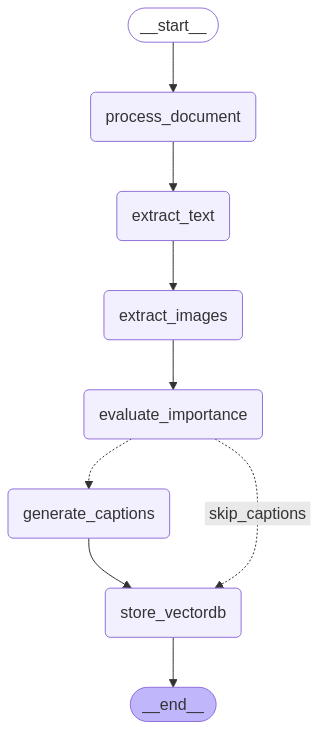

In [ ]:
# 그래프 구축
def build_graph():

    builder = StateGraph(State)

    builder.add_node("process_document", process_document)
    builder.add_node("extract_text", extract_text)
    builder.add_node("extract_images", extract_images)
    builder.add_node("evaluate_importance", evaluate_image_importance)
    builder.add_node("generate_captions", generate_image_captions)
    builder.add_node("store_vectordb", store_in_vectordb)

    builder.add_edge(START, "process_document")
    builder.add_edge("process_document", "extract_text")
    builder.add_edge("extract_text", "extract_images")
    builder.add_edge("extract_images", "evaluate_importance")


    builder.add_conditional_edges(
        "evaluate_importance",
        route_by_importance,
        {
            "generate_captions": "generate_captions",
            "skip_captions": "store_vectordb"
        }
    )

    builder.add_edge("generate_captions", "store_vectordb")
    builder.add_edge("store_vectordb", END)

    return builder

builder = build_graph()
graph = builder.compile()
graph

In [ ]:
# PDF를 처리하고 벡터 DB를 생성하는 메인 함수
def process_pdf_to_vectordb(pdf_path: str) -> str:
    """
    PDF 파일을 처리하여 벡터 DB를 생성하는 함수

    Args:
        pdf_path (str): PDF 파일의 경로 또는 URL

    Returns:
        str: 생성된 벡터 DB의 경로
        Dict[str, str]: 생성된 벡터 DB 정보 (경로 및 컬렉션 이름)
    """
    logger.info(f"PDF 처리 시작: {pdf_path}")

    # 초기 상태 생성
    initial_state = create_initial_state(pdf_path)

    # 그래프 실행
    final_state = graph.invoke(initial_state)

    # 결과 확인
    if final_state["current_step"] == "vectordb_stored" and final_state["vectordb_path"]:
        result_path = final_state["vectordb_path"]
        logger.info(f"PDF 처리 완료, 벡터 DB 경로: {result_path}")

        # 처리 통계 출력
        text_chunks_count = len(final_state["text_chunks"])
        images_count = len(final_state["images"])
        captioned_images = sum(1 for img in final_state["images"] if img.get("caption"))

        logger.info(f"처리 통계: 텍스트 청크 {text_chunks_count}개, 이미지 {images_count}개, 캡션 생성된 이미지 {captioned_images}개")

        return {
            "db_path": result_path,
            "collection_name": "mmrag_collection"
        }

    else:
        error_msg = f"PDF 처리 실패: {final_state['errors']}"
        logger.error(error_msg)
        raise RuntimeError(error_msg)


In [ ]:
pdf_path = "https://storage.googleapis.com/deepmind-media/gemma/Gemma3Report.pdf"
result = process_pdf_to_vectordb(pdf_path)
db_path, collection_name = result["db_path"], result["collection_name"]

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [ ]:
db_path,collection_name

('DB_f23ce26f', 'mmrag_collection')

생성된 DB를 통해 검색을 수행해 보겠습니다.

In [ ]:
db = Chroma(embedding_function=embeddings, collection_name=collection_name, persist_directory=db_path)

retriever = db.as_retriever(search_kwargs={"k": 6})
retriever.invoke(input= "Gemma 3의 성능 향상 방법은 무엇인가요?")


[Document(id='7c5736d8-0ea8-44b2-9b98-9f7d622c1ec1', metadata={'image_id': 'image_2', 'path': 'mm_rag_output/Gemma3Report-with-image-refs_artifacts/image_000002_8b9cd1c021281ab95c607b7d3e4fce21b4c3f93034630c9662b564624e437fe1.png', 'type': 'image'}, page_content='이 그림은 Gemma 2와 Gemma 3의 다양한 사전 훈련된 모델의 일반적인 능력을 요약한 것입니다. 이 그림은 단순화된 요약을 제공하기 위한 것이며 자세한 내용은 부록에 있습니다. 그림은 2B, 9B, 27B의 세 가지 크기에서 Gemma 2(빨간색)와 Gemma 3(파란색)의 성능을 보여주는 세 개의 레이더 차트로 구성됩니다. 각 차트는 코드, 사실성, 추론, 과학, 다국어 및 비전의 6가지 능력에 대한 모델의 성능을 나타냅니다. Gemma 3는 모든 능력에서 Gemma 2보다 성능이 뛰어납니다.'),
 Document(id='0c7353b3-7e9d-4982-b18e-279d3519ce5e', metadata={'image_id': 'image_9', 'path': 'mm_rag_output/Gemma3Report-with-image-refs_artifacts/image_000009_7ef0d0b4063c9af8243998c5ef677c70de3752a650c02493d9b6cd2d52a78f12.png', 'type': 'image'}, page_content='이것은 다양한 모델에 대한 총 암기율을 비교하는 막대 그래프입니다. y축은 백분율로 표시된 암기율을 나타내며, 대수 척도로 표시됩니다. x축은 Gemma 3 (1B, 4B, 12B, 27B), Gemma 2 (2B, 9B, 27B), Gemini 1.5 Flash, Gemma 2B, Gemma 7B 및 PaLM Small을 포함한

RAG도 그대로 수행할 수 있습니다.

In [ ]:
# 테스트 쿼리
test_queries = [
    "Gemma 3의 주요 특징은 무엇인가요?",
    "Gemma 3의 성능 평가 결과를 설명해주세요.",
    "Gemma 3의 멀티모달 능력은 어떻게 되나요?",
    "Gemma 3의 Technical Report에서 활용하는 주요 벤치마크는 무엇인가요?",
    "Gemma 3의 성능이나 구현, 운영 상에서의 한계점이나 이후 발전 방향은 무엇인가요?"
]

# 평가 실행
prompt = ChatPromptTemplate([
    ("user", '''당신은 QA(Question-Answering)을 수행하는 Assistant입니다.
다음의 Context를 이용하여 Question에 한국어로 답변하세요.
정확한 답변을 제공하세요.
만약 모든 Context를 다 확인해도 정보가 없다면, "정보가 부족하여 답변할 수 없습니다."를 출력하세요.
---
Context: {context}
---
Question: {question}''')])

chain = prompt | llm

def simple_rag(query):

    print(f"\n질문 : {query}")
    context_documents = retriever.invoke(query)

    context = " \n---\n ".join([doc.page_content for doc in context_documents])
    types = [doc.metadata.get("type") for doc in context_documents]

    print(f"검색된 문서 유형: {types}")
    #print(f"검색된 문서 내용: {context}")

    result = chain.invoke({"context": context, "question": query})
    print(f"응답: {result.content}")

for query in test_queries:
    simple_rag(query)



질문 : Gemma 3의 주요 특징은 무엇인가요?
검색된 문서 유형: ['image', 'image', 'image', 'text', 'image', 'text']
응답: Gemma 3의 주요 특징은 다음과 같습니다:

*   **멀티모달**: Gemma 3 모델은 SigLIP 비전 인코더와 호환되어 이미지 이해 능력을 갖추고 있습니다.
*   **긴 컨텍스트**: 컨텍스트 크기가 128K 토큰으로 증가했습니다.
*   **다국어**: 데이터 혼합을 재검토하여 모델의 다국어 기능이 향상되었습니다.
*   **향상된 성능**: Gemma 2보다 사전 훈련 및 Instruction Finetuned 버전 모두에서 성능이 뛰어납니다. 특히 수학, 채팅, Instruction Following 및 다국어 능력이 크게 향상되었습니다.
*   **KV-캐시 메모리 감소**: 로컬 및 글로벌 Attention 레이어의 비율을 조정하여 KV-캐시 메모리 사용량을 줄였습니다.
*   **안전성**: 안전 정책에 따라 유해 콘텐츠 생성을 방지하도록 설계되었습니다.

질문 : Gemma 3의 성능 평가 결과를 설명해주세요.
검색된 문서 유형: ['image', 'image', 'image', 'image', 'text', 'text']
응답: Gemma 3는 다양한 벤치마크에서 이전 모델인 Gemma 2 및 Gemini 1.5와 비교하여 성능이 향상되었습니다. 특히, Gemma 3는 MMLU-Pro, LiveCodeBench, Bird-SQL, GPQA Diamond, SimpleQA, FACTS Grounding, Global MMLU-Lite, MATH, HiddenMath 등의 벤치마크에서 더 높은 점수를 얻었습니다. 또한 시각적 이해 벤치마크에서도 Gemma 3는 MMLU, MBPP, HumanEval, N2C, LiveCodeBench, GSM8K, MATH, HiddenMath, BBH, BBEH, IFEval, GMMLU-Lite, ECLeKTic, WMT24 ++

답변과 함께, 검색된 이미지를 같이 보여준다면 어떨까요?


질문 : Gemma 3의 주요 특징은 무엇인가요?
검색된 문서 유형: ['image', 'image', 'image', 'text', 'image', 'text']
응답: Gemma 3의 주요 특징은 다음과 같습니다.

*   **멀티모달:** 이미지 이해 능력을 갖추고 있습니다.
*   **긴 컨텍스트:** 최소 128K 토큰의 긴 컨텍스트를 지원합니다.
*   **다국어:** 더 넓은 범위의 언어를 지원합니다.
*   **향상된 성능:** 사전 훈련 및 Instruction Finetuning 버전 모두에서 Gemma 2보다 성능이 뛰어납니다.
*   **KV-cache 메모리 감소:** 모델 아키텍처 변경을 통해 KV-cache 메모리 사용량을 줄였습니다.
*   **수학, 추론, 채팅 능력 향상:** 새로운 Post-Training 방식을 통해 수학, 추론, 채팅 능력이 크게 향상되었습니다.
검색된 이미지:


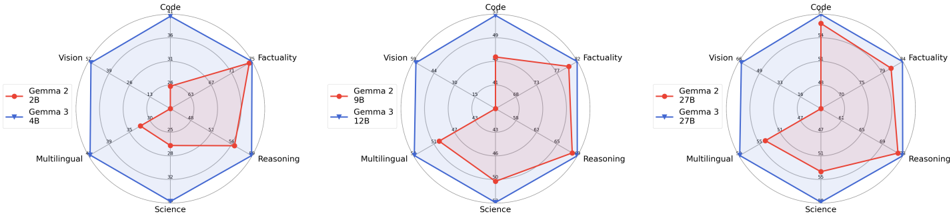

이미지 설명: 이 그림은 Gemma 2와 Gemma 3의 다양한 사전 훈련된 모델의 일반적인 능력을 요약한 것입니다. 이 그림은 단순화된 요약을 제공하기 위한 것이며 자세한 내용은 부록에 있습니다. 그림은 2B, 9B, 27B의 세 가지 크기에서 Gemma 2(빨간색)와 Gemma 3(파란색)의 성능을 보여주는 세 개의 레이더 차트로 구성됩니다. 각 차트는 코드, 사실성, 추론, 과학, 다국어 및 비전의 6가지 능력에 대한 모델의 성능을 나타냅니다. Gemma 3는 모든 능력에서 Gemma 2보다 성능이 뛰어납니다.


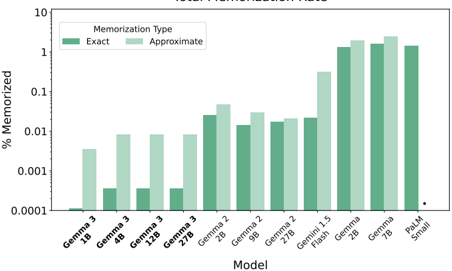

이미지 설명: 이것은 다양한 모델에 대한 총 암기율을 비교하는 막대 그래프입니다. y축은 백분율로 표시된 암기율을 나타내며, 대수 척도로 표시됩니다. x축은 Gemma 3 (1B, 4B, 12B, 27B), Gemma 2 (2B, 9B, 27B), Gemini 1.5 Flash, Gemma 2B, Gemma 7B 및 PaLM Small을 포함한 다양한 모델을 나타냅니다. 각 모델에는 정확한 암기(진한 녹색)와 근사 암기(밝은 녹색)를 나타내는 두 개의 막대가 있습니다. Gemma 3 모델은 이전 모델보다 암기율이 현저히 낮은 것으로 나타났으며, 대부분의 텍스트는 정확한 암기보다 근사 암기로 분류됩니다. 텍스트에서 언급했듯이, 이 그래프는 Gemma 및 Gemini 모델의 암기율을 비교하고 있으며, 가장 새로운 Gemma 3 모델이 왼쪽에 있습니다. 이 그래프는 Gemma 3 모델이 이전 모델보다 장문 텍스트를 훨씬 낮은 비율로 암기한다는 것을 보여줍니다.


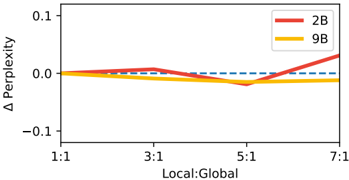

이미지 설명: 이 이미지는 검증 세트의 복잡도에 대한 로컬:글로벌 비율의 영향을 보여주는 선 그래프입니다. x축은 1:1에서 7:1까지의 로컬:글로벌 비율을 나타내고 y축은 복잡도 변화를 나타냅니다. 두 개의 선이 표시되어 있습니다. 하나는 2B 모델(빨간색)이고 다른 하나는 9B 모델(노란색)입니다. 그래프는 로컬:글로벌 비율을 변경해도 복잡도에 미치는 영향이 미미하다는 것을 보여줍니다. Gemma 2 모델에서는 1:1이 사용되고 Gemma 3에서는 5:1이 사용됩니다. 이 절제는 텍스트 전용 모델로 실행됩니다. 이 그래프는 로컬 및 글로벌 자체 주의 레이어에 대한 변경이 추론 중 성능과 메모리 소비에 미치는 영향을 분석한 Fig. 3에 해당합니다. 이 연구는 로컬 및 글로벌 주의 메커니즘 간의 균형을 조정하여 모델 성능에 미치는 영향을 최소화하면서 메모리 사용량을 줄이는 것을 목표로 합니다.


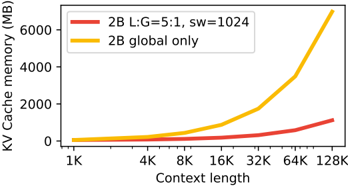

이미지 설명: 이 그래프는 컨텍스트 길이에 따른 KV 캐시 메모리를 보여줍니다. 빨간색 선은 L:G=5:1 및 sw=1024인 2B 아키텍처의 메모리 사용량을 나타내고, 노란색 선은 LLaMa 또는 Gemma 1에서 사용되는 것과 같은 글로벌 주의만 있는 변환기의 메모리 사용량을 나타냅니다. x축은 컨텍스트 길이를 나타내고, y축은 메가바이트(MB) 단위의 KV 캐시 메모리를 나타냅니다. 글로벌 주의만 있는 모델의 메모리 사용량은 컨텍스트 길이가 증가함에 따라 훨씬 더 빠른 속도로 증가합니다. 특히 컨텍스트 길이가 128K일 때 글로벌 주의만 있는 모델은 약 6000MB의 메모리를 사용하는 반면, L:G=5:1 및 sw=1024인 모델은 약 1200MB의 메모리를 사용합니다. 이 그래프는 L:G=5:1 및 sw=1024인 아키텍처가 더 긴 컨텍스트 길이에 대해 KV 캐시 메모리 사용량 측면에서 더 효율적임을 시사합니다. 주변 텍스트는 Gemma 1과 LLaMa에서 사용되는 것과 같이 글로벌 주의만 있는 2B 모델에 비해 아키텍처(L:G=5:1, sw=1024)의 KV 캐시 메모리 사용량에 대한 메모리 사용량을 비교합니다.

질문 : Gemma 3의 성능 평가 결과를 설명해주세요.
검색된 문서 유형: ['image', 'image', 'image', 'image', 'text', 'text']
응답: Gemma 3는 다양한 벤치마크에서 이전 모델인 Gemma 2와 Gemini 1.5를 능가하는 성능을 보입니다. 특히 MMLU-Pro, LiveCodeBench, Bird-SQL (dev), GPQA Diamond, SimpleQA, FACTS Grounding, Global MMLU-Lite, MATH, HiddenMath 등 다양한 분야에서 더 높은 점수를 기록했습니다. 예를 들어, MMLU-Pro 벤치마크에서 Gemma 3 (27B)는 67.5점을 기록하여 Gemma 2 (27B)의 56.9점을 능가합니다. 또한, MATH 벤치마크에서 Gemma 3 (27B)

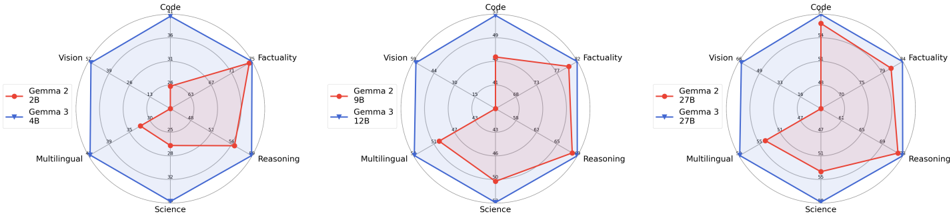

이미지 설명: 이 그림은 Gemma 2와 Gemma 3의 다양한 사전 훈련된 모델의 일반적인 능력을 요약한 것입니다. 이 그림은 단순화된 요약을 제공하기 위한 것이며 자세한 내용은 부록에 있습니다. 그림은 2B, 9B, 27B의 세 가지 크기에서 Gemma 2(빨간색)와 Gemma 3(파란색)의 성능을 보여주는 세 개의 레이더 차트로 구성됩니다. 각 차트는 코드, 사실성, 추론, 과학, 다국어 및 비전의 6가지 능력에 대한 모델의 성능을 나타냅니다. Gemma 3는 모든 능력에서 Gemma 2보다 성능이 뛰어납니다.


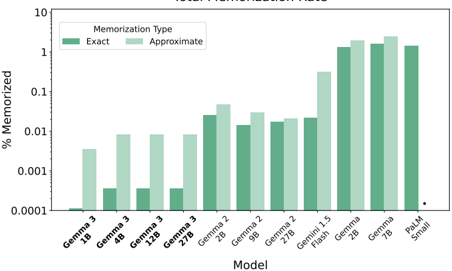

이미지 설명: 이것은 다양한 모델에 대한 총 암기율을 비교하는 막대 그래프입니다. y축은 백분율로 표시된 암기율을 나타내며, 대수 척도로 표시됩니다. x축은 Gemma 3 (1B, 4B, 12B, 27B), Gemma 2 (2B, 9B, 27B), Gemini 1.5 Flash, Gemma 2B, Gemma 7B 및 PaLM Small을 포함한 다양한 모델을 나타냅니다. 각 모델에는 정확한 암기(진한 녹색)와 근사 암기(밝은 녹색)를 나타내는 두 개의 막대가 있습니다. Gemma 3 모델은 이전 모델보다 암기율이 현저히 낮은 것으로 나타났으며, 대부분의 텍스트는 정확한 암기보다 근사 암기로 분류됩니다. 텍스트에서 언급했듯이, 이 그래프는 Gemma 및 Gemini 모델의 암기율을 비교하고 있으며, 가장 새로운 Gemma 3 모델이 왼쪽에 있습니다. 이 그래프는 Gemma 3 모델이 이전 모델보다 장문 텍스트를 훨씬 낮은 비율로 암기한다는 것을 보여줍니다.


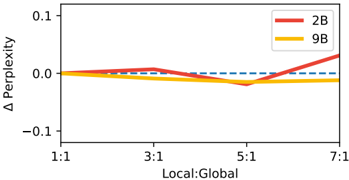

이미지 설명: 이 이미지는 검증 세트의 복잡도에 대한 로컬:글로벌 비율의 영향을 보여주는 선 그래프입니다. x축은 1:1에서 7:1까지의 로컬:글로벌 비율을 나타내고 y축은 복잡도 변화를 나타냅니다. 두 개의 선이 표시되어 있습니다. 하나는 2B 모델(빨간색)이고 다른 하나는 9B 모델(노란색)입니다. 그래프는 로컬:글로벌 비율을 변경해도 복잡도에 미치는 영향이 미미하다는 것을 보여줍니다. Gemma 2 모델에서는 1:1이 사용되고 Gemma 3에서는 5:1이 사용됩니다. 이 절제는 텍스트 전용 모델로 실행됩니다. 이 그래프는 로컬 및 글로벌 자체 주의 레이어에 대한 변경이 추론 중 성능과 메모리 소비에 미치는 영향을 분석한 Fig. 3에 해당합니다. 이 연구는 로컬 및 글로벌 주의 메커니즘 간의 균형을 조정하여 모델 성능에 미치는 영향을 최소화하면서 메모리 사용량을 줄이는 것을 목표로 합니다.


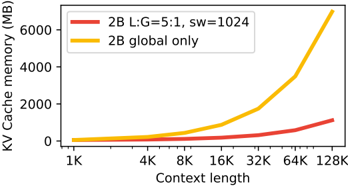

이미지 설명: 이 그래프는 컨텍스트 길이에 따른 KV 캐시 메모리를 보여줍니다. 빨간색 선은 L:G=5:1 및 sw=1024인 2B 아키텍처의 메모리 사용량을 나타내고, 노란색 선은 LLaMa 또는 Gemma 1에서 사용되는 것과 같은 글로벌 주의만 있는 변환기의 메모리 사용량을 나타냅니다. x축은 컨텍스트 길이를 나타내고, y축은 메가바이트(MB) 단위의 KV 캐시 메모리를 나타냅니다. 글로벌 주의만 있는 모델의 메모리 사용량은 컨텍스트 길이가 증가함에 따라 훨씬 더 빠른 속도로 증가합니다. 특히 컨텍스트 길이가 128K일 때 글로벌 주의만 있는 모델은 약 6000MB의 메모리를 사용하는 반면, L:G=5:1 및 sw=1024인 모델은 약 1200MB의 메모리를 사용합니다. 이 그래프는 L:G=5:1 및 sw=1024인 아키텍처가 더 긴 컨텍스트 길이에 대해 KV 캐시 메모리 사용량 측면에서 더 효율적임을 시사합니다. 주변 텍스트는 Gemma 1과 LLaMa에서 사용되는 것과 같이 글로벌 주의만 있는 2B 모델에 비해 아키텍처(L:G=5:1, sw=1024)의 KV 캐시 메모리 사용량에 대한 메모리 사용량을 비교합니다.

질문 : Gemma 3의 멀티모달 능력은 어떻게 되나요?
검색된 문서 유형: ['image', 'image', 'image', 'text', 'image', 'text']
응답: Gemma 3 모델은 SigLIP vision encoder의 맞춤 버전을 지원하여 멀티모달 기능을 제공합니다. 언어 모델은 이미지를 SigLIP에 의해 인코딩된 소프트 토큰의 시퀀스로 취급합니다. 이미지 처리의 추론 비용을 줄이기 위해 비전 임베딩을 256개 벡터의 고정 크기로 압축합니다. 인코더는 고정 해상도에서 작동하며 LLaVA에서 영감을 받아 Pan and Scan(P&S) 방법을 통해 유연한 해상도를 지원합니다.
검색된 이미지:


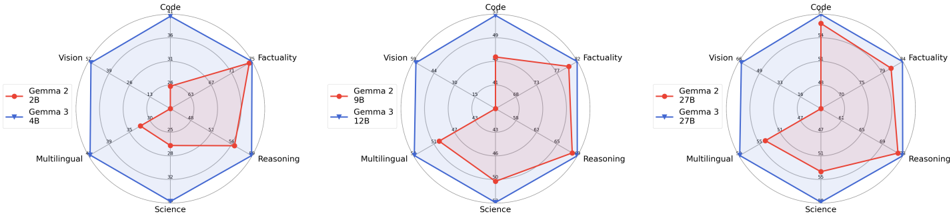

이미지 설명: 이 그림은 Gemma 2와 Gemma 3의 다양한 사전 훈련된 모델의 일반적인 능력을 요약한 것입니다. 이 그림은 단순화된 요약을 제공하기 위한 것이며 자세한 내용은 부록에 있습니다. 그림은 2B, 9B, 27B의 세 가지 크기에서 Gemma 2(빨간색)와 Gemma 3(파란색)의 성능을 보여주는 세 개의 레이더 차트로 구성됩니다. 각 차트는 코드, 사실성, 추론, 과학, 다국어 및 비전의 6가지 능력에 대한 모델의 성능을 나타냅니다. Gemma 3는 모든 능력에서 Gemma 2보다 성능이 뛰어납니다.


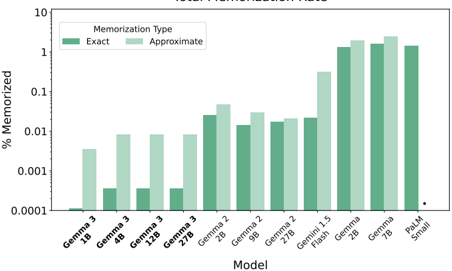

이미지 설명: 이것은 다양한 모델에 대한 총 암기율을 비교하는 막대 그래프입니다. y축은 백분율로 표시된 암기율을 나타내며, 대수 척도로 표시됩니다. x축은 Gemma 3 (1B, 4B, 12B, 27B), Gemma 2 (2B, 9B, 27B), Gemini 1.5 Flash, Gemma 2B, Gemma 7B 및 PaLM Small을 포함한 다양한 모델을 나타냅니다. 각 모델에는 정확한 암기(진한 녹색)와 근사 암기(밝은 녹색)를 나타내는 두 개의 막대가 있습니다. Gemma 3 모델은 이전 모델보다 암기율이 현저히 낮은 것으로 나타났으며, 대부분의 텍스트는 정확한 암기보다 근사 암기로 분류됩니다. 텍스트에서 언급했듯이, 이 그래프는 Gemma 및 Gemini 모델의 암기율을 비교하고 있으며, 가장 새로운 Gemma 3 모델이 왼쪽에 있습니다. 이 그래프는 Gemma 3 모델이 이전 모델보다 장문 텍스트를 훨씬 낮은 비율로 암기한다는 것을 보여줍니다.


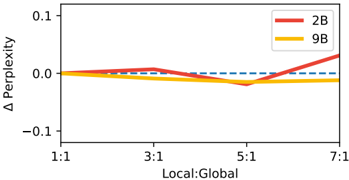

이미지 설명: 이 이미지는 검증 세트의 복잡도에 대한 로컬:글로벌 비율의 영향을 보여주는 선 그래프입니다. x축은 1:1에서 7:1까지의 로컬:글로벌 비율을 나타내고 y축은 복잡도 변화를 나타냅니다. 두 개의 선이 표시되어 있습니다. 하나는 2B 모델(빨간색)이고 다른 하나는 9B 모델(노란색)입니다. 그래프는 로컬:글로벌 비율을 변경해도 복잡도에 미치는 영향이 미미하다는 것을 보여줍니다. Gemma 2 모델에서는 1:1이 사용되고 Gemma 3에서는 5:1이 사용됩니다. 이 절제는 텍스트 전용 모델로 실행됩니다. 이 그래프는 로컬 및 글로벌 자체 주의 레이어에 대한 변경이 추론 중 성능과 메모리 소비에 미치는 영향을 분석한 Fig. 3에 해당합니다. 이 연구는 로컬 및 글로벌 주의 메커니즘 간의 균형을 조정하여 모델 성능에 미치는 영향을 최소화하면서 메모리 사용량을 줄이는 것을 목표로 합니다.


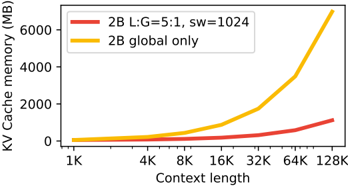

이미지 설명: 이 그래프는 컨텍스트 길이에 따른 KV 캐시 메모리를 보여줍니다. 빨간색 선은 L:G=5:1 및 sw=1024인 2B 아키텍처의 메모리 사용량을 나타내고, 노란색 선은 LLaMa 또는 Gemma 1에서 사용되는 것과 같은 글로벌 주의만 있는 변환기의 메모리 사용량을 나타냅니다. x축은 컨텍스트 길이를 나타내고, y축은 메가바이트(MB) 단위의 KV 캐시 메모리를 나타냅니다. 글로벌 주의만 있는 모델의 메모리 사용량은 컨텍스트 길이가 증가함에 따라 훨씬 더 빠른 속도로 증가합니다. 특히 컨텍스트 길이가 128K일 때 글로벌 주의만 있는 모델은 약 6000MB의 메모리를 사용하는 반면, L:G=5:1 및 sw=1024인 모델은 약 1200MB의 메모리를 사용합니다. 이 그래프는 L:G=5:1 및 sw=1024인 아키텍처가 더 긴 컨텍스트 길이에 대해 KV 캐시 메모리 사용량 측면에서 더 효율적임을 시사합니다. 주변 텍스트는 Gemma 1과 LLaMa에서 사용되는 것과 같이 글로벌 주의만 있는 2B 모델에 비해 아키텍처(L:G=5:1, sw=1024)의 KV 캐시 메모리 사용량에 대한 메모리 사용량을 비교합니다.

질문 : Gemma 3의 Technical Report에서 활용하는 주요 벤치마크는 무엇인가요?
검색된 문서 유형: ['image', 'image', 'image', 'text', 'text', 'image']
응답: Gemma 3 Technical Report에서 활용하는 주요 벤치마크는 MMLU-Pro, LiveCodeBench, Bird-SQL (dev), GPQA Diamond, SimpleQA, FACTS Grounding, Global MMLU-Lite, MATH, HiddenMath, MMMU (val) 입니다.
검색된 이미지:


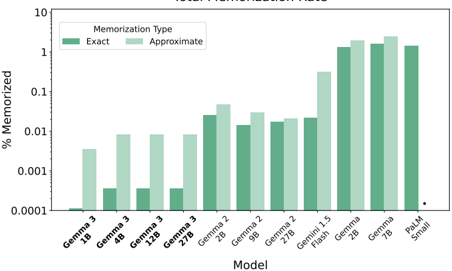

이미지 설명: 이것은 다양한 모델에 대한 총 암기율을 비교하는 막대 그래프입니다. y축은 백분율로 표시된 암기율을 나타내며, 대수 척도로 표시됩니다. x축은 Gemma 3 (1B, 4B, 12B, 27B), Gemma 2 (2B, 9B, 27B), Gemini 1.5 Flash, Gemma 2B, Gemma 7B 및 PaLM Small을 포함한 다양한 모델을 나타냅니다. 각 모델에는 정확한 암기(진한 녹색)와 근사 암기(밝은 녹색)를 나타내는 두 개의 막대가 있습니다. Gemma 3 모델은 이전 모델보다 암기율이 현저히 낮은 것으로 나타났으며, 대부분의 텍스트는 정확한 암기보다 근사 암기로 분류됩니다. 텍스트에서 언급했듯이, 이 그래프는 Gemma 및 Gemini 모델의 암기율을 비교하고 있으며, 가장 새로운 Gemma 3 모델이 왼쪽에 있습니다. 이 그래프는 Gemma 3 모델이 이전 모델보다 장문 텍스트를 훨씬 낮은 비율로 암기한다는 것을 보여줍니다.


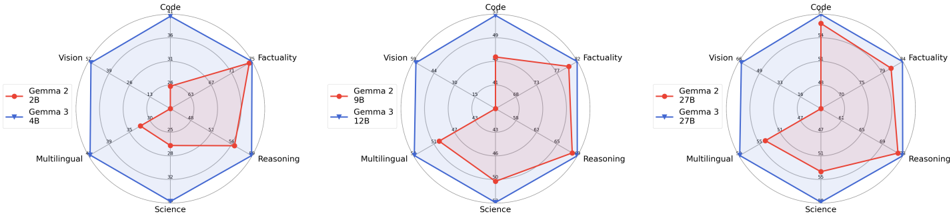

이미지 설명: 이 그림은 Gemma 2와 Gemma 3의 다양한 사전 훈련된 모델의 일반적인 능력을 요약한 것입니다. 이 그림은 단순화된 요약을 제공하기 위한 것이며 자세한 내용은 부록에 있습니다. 그림은 2B, 9B, 27B의 세 가지 크기에서 Gemma 2(빨간색)와 Gemma 3(파란색)의 성능을 보여주는 세 개의 레이더 차트로 구성됩니다. 각 차트는 코드, 사실성, 추론, 과학, 다국어 및 비전의 6가지 능력에 대한 모델의 성능을 나타냅니다. Gemma 3는 모든 능력에서 Gemma 2보다 성능이 뛰어납니다.


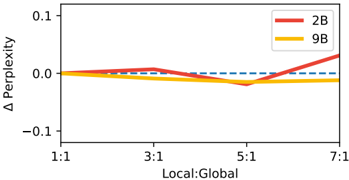

이미지 설명: 이 이미지는 검증 세트의 복잡도에 대한 로컬:글로벌 비율의 영향을 보여주는 선 그래프입니다. x축은 1:1에서 7:1까지의 로컬:글로벌 비율을 나타내고 y축은 복잡도 변화를 나타냅니다. 두 개의 선이 표시되어 있습니다. 하나는 2B 모델(빨간색)이고 다른 하나는 9B 모델(노란색)입니다. 그래프는 로컬:글로벌 비율을 변경해도 복잡도에 미치는 영향이 미미하다는 것을 보여줍니다. Gemma 2 모델에서는 1:1이 사용되고 Gemma 3에서는 5:1이 사용됩니다. 이 절제는 텍스트 전용 모델로 실행됩니다. 이 그래프는 로컬 및 글로벌 자체 주의 레이어에 대한 변경이 추론 중 성능과 메모리 소비에 미치는 영향을 분석한 Fig. 3에 해당합니다. 이 연구는 로컬 및 글로벌 주의 메커니즘 간의 균형을 조정하여 모델 성능에 미치는 영향을 최소화하면서 메모리 사용량을 줄이는 것을 목표로 합니다.


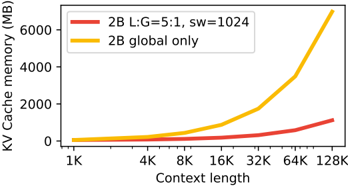

이미지 설명: 이 그래프는 컨텍스트 길이에 따른 KV 캐시 메모리를 보여줍니다. 빨간색 선은 L:G=5:1 및 sw=1024인 2B 아키텍처의 메모리 사용량을 나타내고, 노란색 선은 LLaMa 또는 Gemma 1에서 사용되는 것과 같은 글로벌 주의만 있는 변환기의 메모리 사용량을 나타냅니다. x축은 컨텍스트 길이를 나타내고, y축은 메가바이트(MB) 단위의 KV 캐시 메모리를 나타냅니다. 글로벌 주의만 있는 모델의 메모리 사용량은 컨텍스트 길이가 증가함에 따라 훨씬 더 빠른 속도로 증가합니다. 특히 컨텍스트 길이가 128K일 때 글로벌 주의만 있는 모델은 약 6000MB의 메모리를 사용하는 반면, L:G=5:1 및 sw=1024인 모델은 약 1200MB의 메모리를 사용합니다. 이 그래프는 L:G=5:1 및 sw=1024인 아키텍처가 더 긴 컨텍스트 길이에 대해 KV 캐시 메모리 사용량 측면에서 더 효율적임을 시사합니다. 주변 텍스트는 Gemma 1과 LLaMa에서 사용되는 것과 같이 글로벌 주의만 있는 2B 모델에 비해 아키텍처(L:G=5:1, sw=1024)의 KV 캐시 메모리 사용량에 대한 메모리 사용량을 비교합니다.

질문 : Gemma 3의 성능이나 구현, 운영 상에서의 한계점이나 이후 발전 방향은 무엇인가요?
검색된 문서 유형: ['image', 'image', 'image', 'image', 'text', 'text']
응답: 정보가 부족하여 답변할 수 없습니다.
검색된 이미지:


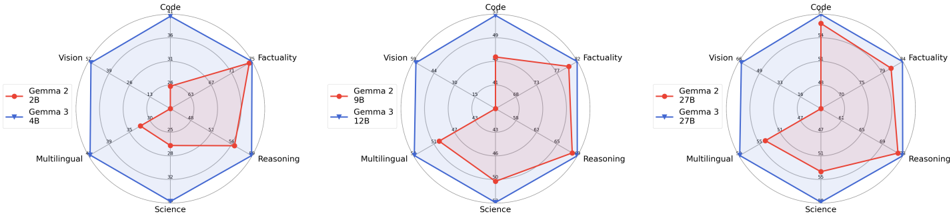

이미지 설명: 이 그림은 Gemma 2와 Gemma 3의 다양한 사전 훈련된 모델의 일반적인 능력을 요약한 것입니다. 이 그림은 단순화된 요약을 제공하기 위한 것이며 자세한 내용은 부록에 있습니다. 그림은 2B, 9B, 27B의 세 가지 크기에서 Gemma 2(빨간색)와 Gemma 3(파란색)의 성능을 보여주는 세 개의 레이더 차트로 구성됩니다. 각 차트는 코드, 사실성, 추론, 과학, 다국어 및 비전의 6가지 능력에 대한 모델의 성능을 나타냅니다. Gemma 3는 모든 능력에서 Gemma 2보다 성능이 뛰어납니다.


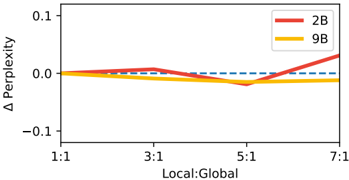

이미지 설명: 이 이미지는 검증 세트의 복잡도에 대한 로컬:글로벌 비율의 영향을 보여주는 선 그래프입니다. x축은 1:1에서 7:1까지의 로컬:글로벌 비율을 나타내고 y축은 복잡도 변화를 나타냅니다. 두 개의 선이 표시되어 있습니다. 하나는 2B 모델(빨간색)이고 다른 하나는 9B 모델(노란색)입니다. 그래프는 로컬:글로벌 비율을 변경해도 복잡도에 미치는 영향이 미미하다는 것을 보여줍니다. Gemma 2 모델에서는 1:1이 사용되고 Gemma 3에서는 5:1이 사용됩니다. 이 절제는 텍스트 전용 모델로 실행됩니다. 이 그래프는 로컬 및 글로벌 자체 주의 레이어에 대한 변경이 추론 중 성능과 메모리 소비에 미치는 영향을 분석한 Fig. 3에 해당합니다. 이 연구는 로컬 및 글로벌 주의 메커니즘 간의 균형을 조정하여 모델 성능에 미치는 영향을 최소화하면서 메모리 사용량을 줄이는 것을 목표로 합니다.


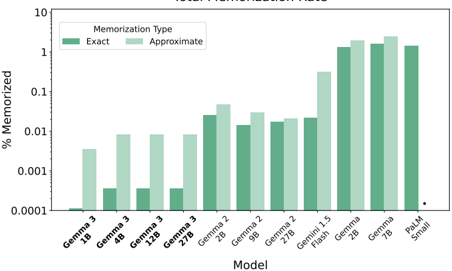

이미지 설명: 이것은 다양한 모델에 대한 총 암기율을 비교하는 막대 그래프입니다. y축은 백분율로 표시된 암기율을 나타내며, 대수 척도로 표시됩니다. x축은 Gemma 3 (1B, 4B, 12B, 27B), Gemma 2 (2B, 9B, 27B), Gemini 1.5 Flash, Gemma 2B, Gemma 7B 및 PaLM Small을 포함한 다양한 모델을 나타냅니다. 각 모델에는 정확한 암기(진한 녹색)와 근사 암기(밝은 녹색)를 나타내는 두 개의 막대가 있습니다. Gemma 3 모델은 이전 모델보다 암기율이 현저히 낮은 것으로 나타났으며, 대부분의 텍스트는 정확한 암기보다 근사 암기로 분류됩니다. 텍스트에서 언급했듯이, 이 그래프는 Gemma 및 Gemini 모델의 암기율을 비교하고 있으며, 가장 새로운 Gemma 3 모델이 왼쪽에 있습니다. 이 그래프는 Gemma 3 모델이 이전 모델보다 장문 텍스트를 훨씬 낮은 비율로 암기한다는 것을 보여줍니다.


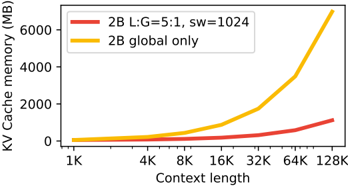

이미지 설명: 이 그래프는 컨텍스트 길이에 따른 KV 캐시 메모리를 보여줍니다. 빨간색 선은 L:G=5:1 및 sw=1024인 2B 아키텍처의 메모리 사용량을 나타내고, 노란색 선은 LLaMa 또는 Gemma 1에서 사용되는 것과 같은 글로벌 주의만 있는 변환기의 메모리 사용량을 나타냅니다. x축은 컨텍스트 길이를 나타내고, y축은 메가바이트(MB) 단위의 KV 캐시 메모리를 나타냅니다. 글로벌 주의만 있는 모델의 메모리 사용량은 컨텍스트 길이가 증가함에 따라 훨씬 더 빠른 속도로 증가합니다. 특히 컨텍스트 길이가 128K일 때 글로벌 주의만 있는 모델은 약 6000MB의 메모리를 사용하는 반면, L:G=5:1 및 sw=1024인 모델은 약 1200MB의 메모리를 사용합니다. 이 그래프는 L:G=5:1 및 sw=1024인 아키텍처가 더 긴 컨텍스트 길이에 대해 KV 캐시 메모리 사용량 측면에서 더 효율적임을 시사합니다. 주변 텍스트는 Gemma 1과 LLaMa에서 사용되는 것과 같이 글로벌 주의만 있는 2B 모델에 비해 아키텍처(L:G=5:1, sw=1024)의 KV 캐시 메모리 사용량에 대한 메모리 사용량을 비교합니다.


In [ ]:
from IPython.display import Image, Markdown, display

def simple_rag_with_image(query):
    print(f"\n질문 : {query}")
    context_documents = retriever.invoke(query)

    context = " \n---\n ".join([doc.page_content for doc in context_documents])
    types = [doc.metadata.get("type") for doc in context_documents]

    print(f"검색된 문서 유형: {types}")
    #print(f"검색된 문서 내용: {context}")

    result = chain.invoke({"context": context, "question": query})
    print(f"응답: {result.content}")

    print("검색된 이미지:")
    for doc in context_documents:
        if doc.metadata.get("type") == "image":
            img = doc.metadata['path']
            display(Image(img))
            print(f"이미지 설명: {doc.page_content}")

for query in test_queries:
    simple_rag_with_image(query)
